In [ ]:
# Unzip images to a custom data folder
!unzip -q /content/merge_data.zip -d /content

## EDA

In [ ]:
import os
import glob
import yaml
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import cv2
import random
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import pandas as pd

In [ ]:
# Basic Setup - Load dataset
data_path = '/content/data'
yaml_path = '/content/data/data.yaml'

### Waste Categories

In [ ]:
# Load classes from yaml
with open(yaml_path, 'r') as f:
    data_dict = yaml.safe_load(f)
    classes = data_dict['names']

print(f"Classes: {classes}")

Classes: ['BIODEGRADABLE', 'CARDBOARD', 'GLASS', 'METAL', 'PAPER', 'PLASTIC']


### Dataset Sizes

In [ ]:
# Get image and label files
images_path = os.path.join(data_path, "images")
labels_path = os.path.join(data_path, "labels")

image_files = glob.glob(os.path.join(images_path, "*.jpg")) + \
              glob.glob(os.path.join(images_path, "*.png"))

label_files = glob.glob(os.path.join(labels_path, "*.txt"))

print(f"Number of images: {len(image_files)}")
print(f"Number of label files: {len(label_files)}")

Number of images: 17365
Number of label files: 17365


### Class Distribution Analysis

In [ ]:
# Analyze class distribution
class_counts = [0] * len(classes)

# Process each label file
for label_file in tqdm(label_files, desc="Counting classes"):
    with open(label_file, 'r') as f:
        for line in f:
            # YOLO format: class_id x_center y_center width height
            parts = line.strip().split()
            class_id = int(parts[0])
            if 0 <= class_id < len(classes):
                class_counts[class_id] += 1

# Calculate total objects
total_objects = sum(class_counts)
print(f"Total objects: {total_objects}")

Counting classes: 100%|██████████| 17365/17365 [00:00<00:00, 30563.03it/s]

Total objects: 122557


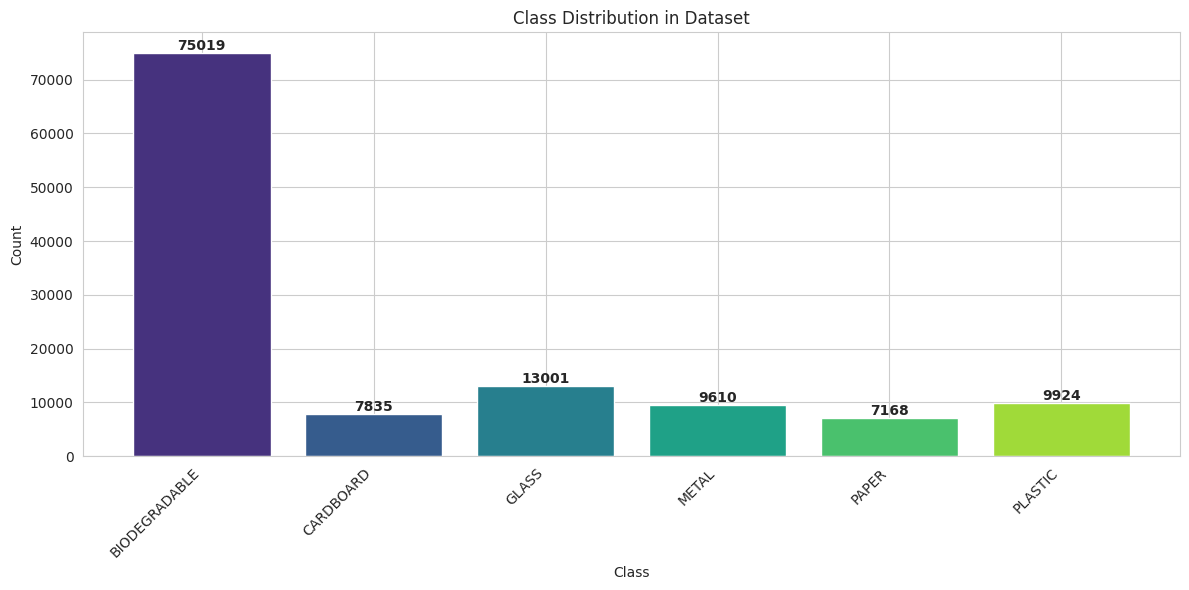

In [ ]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create bar chart
bars = plt.bar(range(len(classes)), class_counts, color=sns.color_palette("viridis", len(classes)))

# Add counts on top of bars
for i, bar in enumerate(bars):
    count = class_counts[i]
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.5,
        str(count),
        ha='center',
        va='bottom',
        fontweight='bold'
    )

# Set labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Dataset')

# Set x-axis ticks with class names
plt.xticks(range(len(classes)), classes, rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [ ]:
# Print class distribution statistics
print("\nClass Distribution:")
for i, (name, count) in enumerate(zip(classes, class_counts)):
    percentage = (count / total_objects) * 100 if total_objects > 0 else 0
    print(f"{i}: {name}: {count} ({percentage:.2f}%)")


Class Distribution:
0: BIODEGRADABLE: 75019 (61.21%)
1: CARDBOARD: 7835 (6.39%)
2: GLASS: 13001 (10.61%)
3: METAL: 9610 (7.84%)
4: PAPER: 7168 (5.85%)
5: PLASTIC: 9924 (8.10%)


### Image Dimensions Analysis

In [ ]:
# Collect image dimensions
widths = []
heights = []
aspects = []
sizes = []
common_dimensions = []

for img_path in tqdm(image_files, desc="Analyzing images"):
    try:
        img = Image.open(img_path)
        width, height = img.size
        aspect = width / height
        area = width * height

        # Store data
        widths.append(width)
        heights.append(height)
        aspects.append(aspect)
        sizes.append(area)
        common_dimensions.append((width, height))
    except:
        print(f"Error processing {img_path}")

# Create a figure with subplots
plt.figure(figsize=(20, 15))

Analyzing images: 100%|██████████| 17365/17365 [00:01<00:00, 11640.50it/s]


<Figure size 2000x1500 with 0 Axes>

<Figure size 2000x1500 with 0 Axes>

Text(0, 0.5, 'Count')

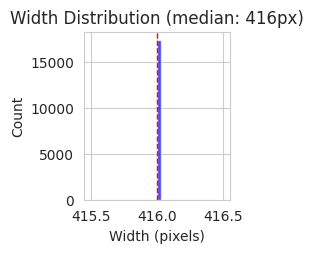

In [ ]:
# 1. Width distribution
plt.subplot(2, 3, 1)
plt.hist(widths, bins=30, alpha=0.7, color='blue')
plt.axvline(np.median(widths), color='red', linestyle='dashed', linewidth=1)
plt.title(f'Width Distribution (median: {np.median(widths):.0f}px)')
plt.xlabel('Width (pixels)')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

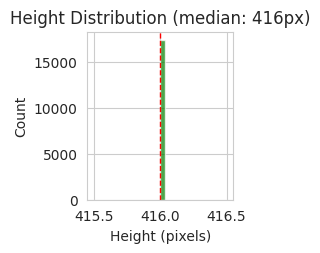

In [ ]:
# 2. Height distribution
plt.subplot(2, 3, 2)
plt.hist(heights, bins=30, alpha=0.7, color='green')
plt.axvline(np.median(heights), color='red', linestyle='dashed', linewidth=1)
plt.title(f'Height Distribution (median: {np.median(heights):.0f}px)')
plt.xlabel('Height (pixels)')
plt.ylabel('Count')

### Random Images from Each Category

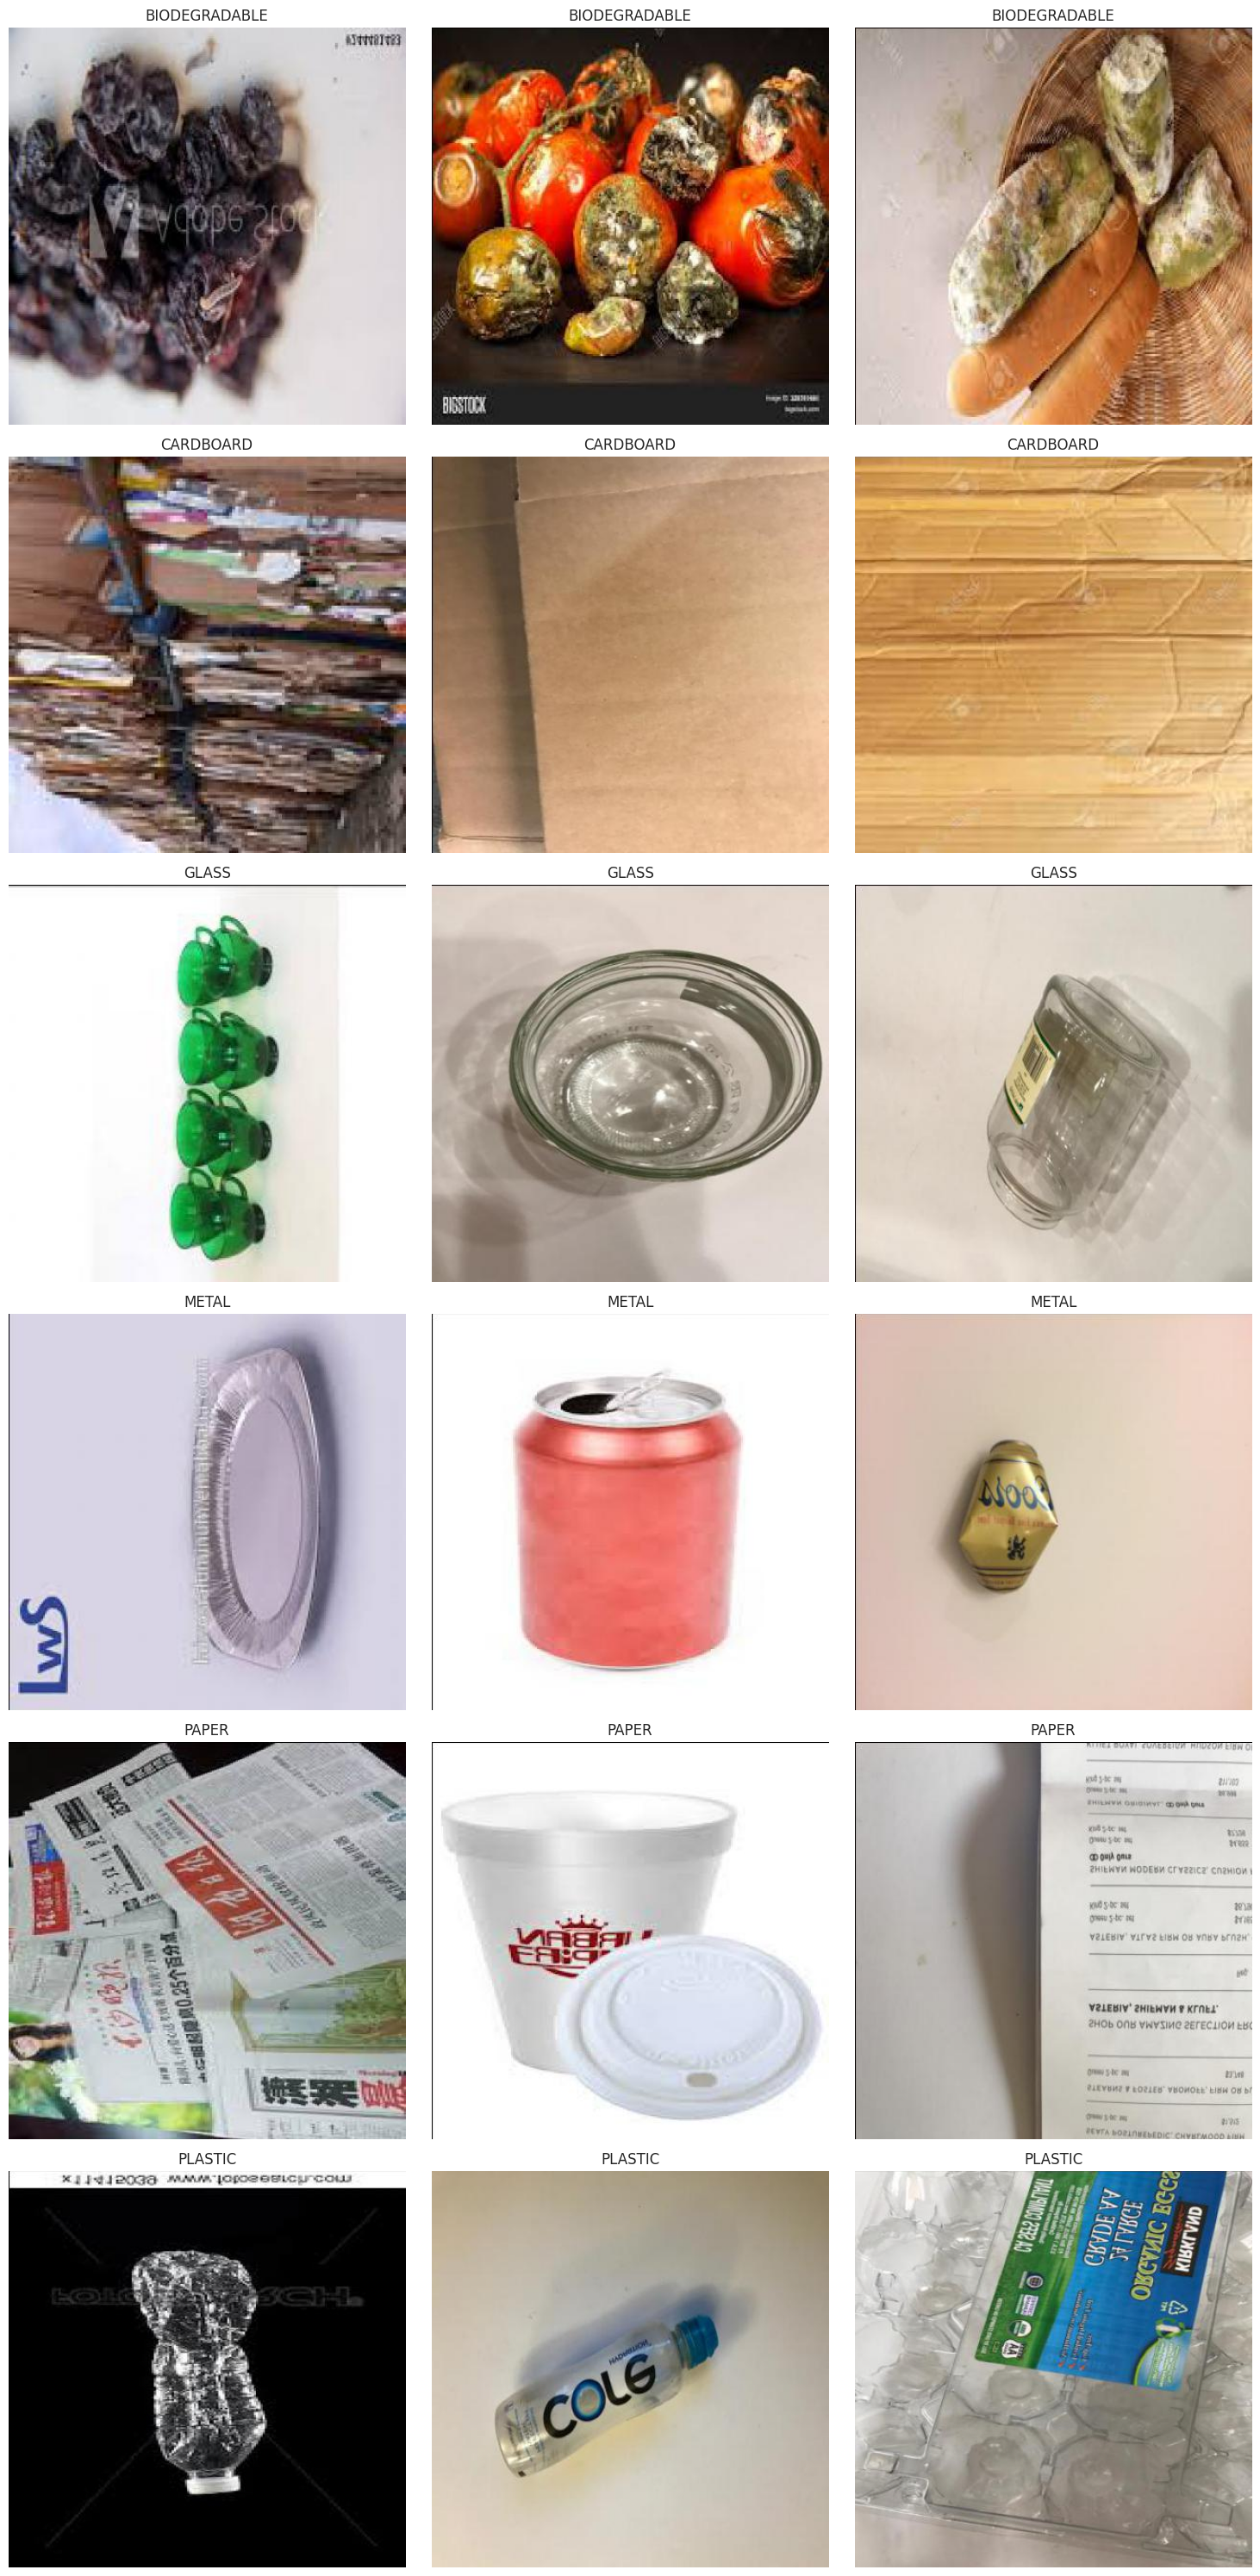

In [ ]:
# Create image to label mapping
image_to_label = {}
for label_file in label_files:
    base_name = os.path.basename(label_file)
    image_name = os.path.splitext(base_name)[0]
    for ext in ['.jpg', '.png']:
        potential_img = os.path.join(images_path, image_name + ext)
        if os.path.exists(potential_img):
            image_to_label[potential_img] = label_file
            break

# Organize images by class
class_to_images = {i: [] for i in range(len(classes))}

for img_path, label_path in image_to_label.items():
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        if 0 <= class_id < len(classes):
            class_to_images[class_id].append(img_path)
            break  # Just add the image once to this class

# Show examples per class
rows = len(classes)
cols = 3  # Show 3 examples per class
plt.figure(figsize=(15, 5 * rows))

for class_id in range(len(classes)):
    images = class_to_images[class_id]
    if not images:
        print(f"No images for class {class_id}: {classes[class_id]}")
        continue

    # Get up to 3 random images for this class
    samples = random.sample(images, min(3, len(images)))

    for i, img_path in enumerate(samples):
        # Display the image
        img = Image.open(img_path)

        plt.subplot(rows, cols, class_id * cols + i + 1)
        plt.imshow(img)
        plt.title(f"{classes[class_id]}")
        plt.axis('off')

plt.tight_layout()
plt.savefig('waste_categories.png')
plt.show()

### Bounding Box Analysis

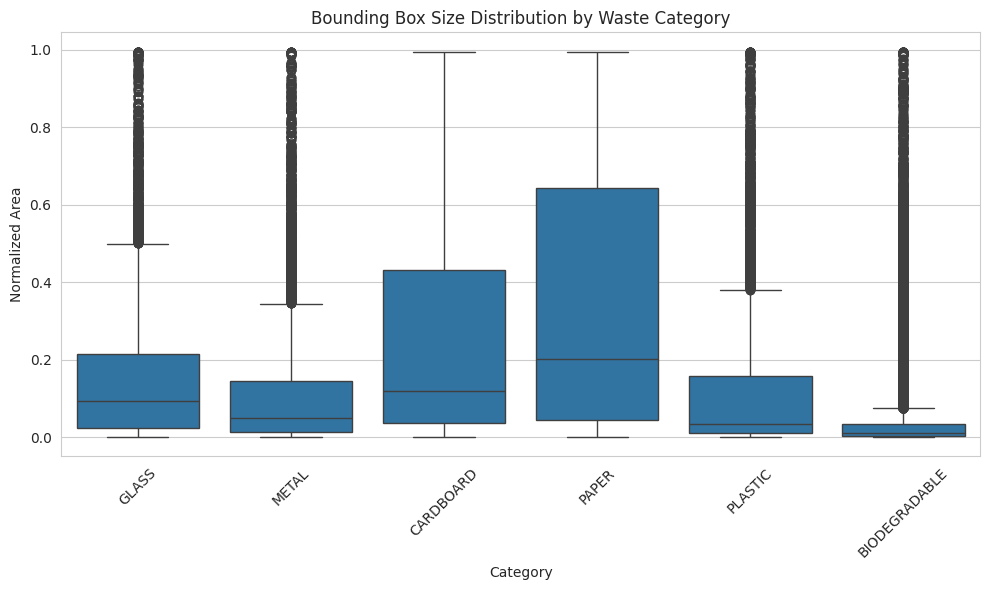

In [ ]:
# BOUNDING BOX ANALYSIS
box_dimensions = {'width': [], 'height': [], 'area': [], 'class': []}

for label_file in label_files:
    with open(label_file, 'r') as f:
        annotations = f.readlines()

    for ann in annotations:
        values = ann.strip().split()
        if len(values) == 5:
            class_id = int(values[0])
            if class_id < len(classes):
                _, _, width, height = map(float, values[1:])
                box_dimensions['width'].append(width)
                box_dimensions['height'].append(height)
                box_dimensions['area'].append(width * height)
                box_dimensions['class'].append(classes[class_id])

# Plot bounding box size distribution by waste category
df = pd.DataFrame(box_dimensions)
plt.figure(figsize=(10, 6))
sns.boxplot(x='class', y='area', data=df)
plt.title('Bounding Box Size Distribution by Waste Category')
plt.xlabel('Category')
plt.ylabel('Normalized Area')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Objects per Image Analysis

In [ ]:
# Count objects per image
objects_per_image = []

for label_file in label_files:
    with open(label_file, 'r') as f:
        annotations = f.readlines()

    # Count total objects in this image
    num_objects = len(annotations)
    objects_per_image.append(num_objects)

# Calculate basic statistics
total_images = len(objects_per_image)
total_objects = sum(objects_per_image)
avg_objects = total_objects / total_images if total_images > 0 else 0

print(f"Total images: {total_images}")
print(f"Total objects: {total_objects}")
print(f"Average objects per image: {avg_objects:.2f}")
print(f"Median objects per image: {np.median(objects_per_image)}")
print(f"Max objects in any image: {max(objects_per_image)}")

Total images: 17365
Total objects: 122557
Average objects per image: 7.06
Median objects per image: 2.0
Max objects in any image: 358


#### Basic Histogram Visualization

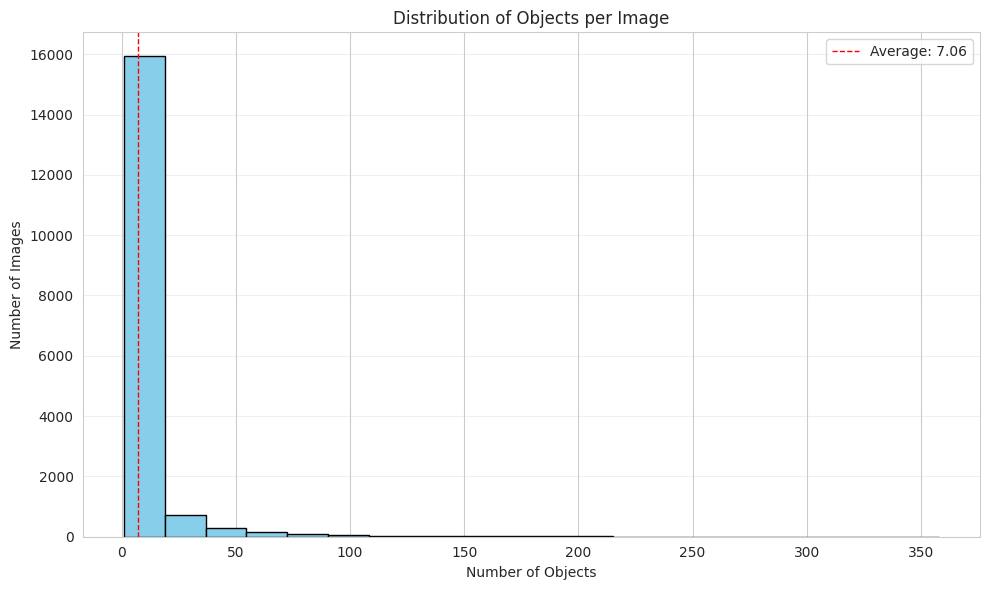

In [ ]:
# Create a simple histogram
plt.figure(figsize=(10, 6))
plt.hist(objects_per_image, bins=20, color='skyblue', edgecolor='black')
plt.axvline(avg_objects, color='red', linestyle='dashed', linewidth=1, label=f'Average: {avg_objects:.2f}')
plt.title('Distribution of Objects per Image')
plt.xlabel('Number of Objects')
plt.ylabel('Number of Images')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

#### Improved Visualization - Truncated Histogram
Since the distribution is likely skewed, let's create a truncated histogram that focuses on the most common range:

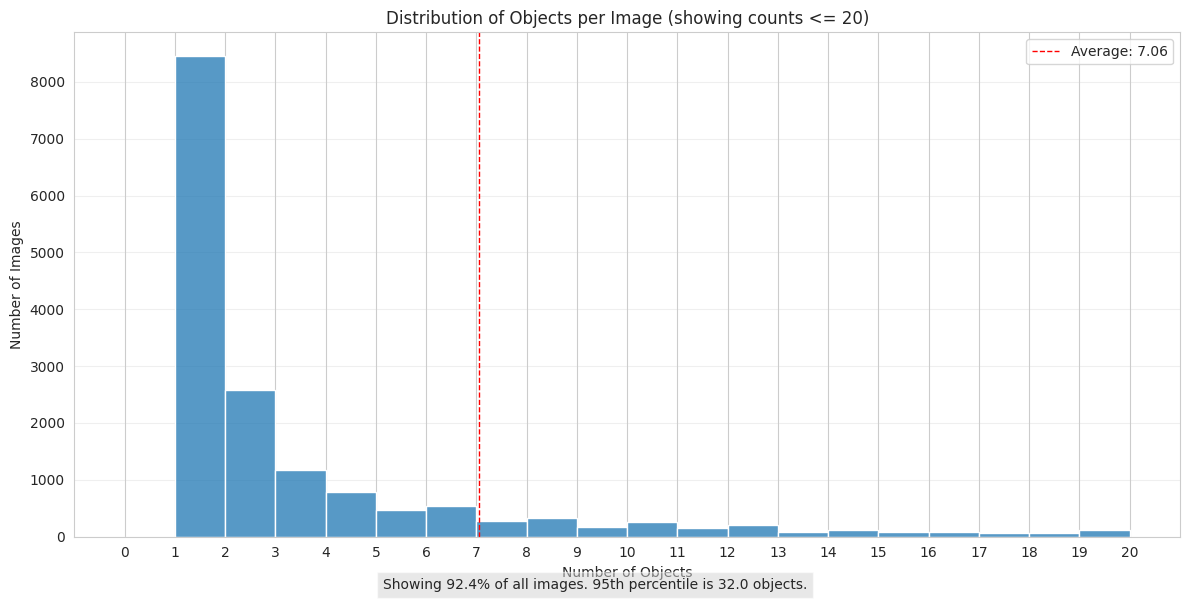

In [ ]:
# Create a truncated histogram - focusing on the range where most data is
plt.figure(figsize=(12, 6))
max_display = 20  # Display bins only up to this number
filtered_counts = [count for count in objects_per_image if count <= max_display]
percentile_95 = np.percentile(objects_per_image, 95)

sns.histplot(filtered_counts, bins=range(0, max_display + 1), kde=False)
plt.axvline(avg_objects, color='red', linestyle='dashed', linewidth=1, label=f'Average: {avg_objects:.2f}')
plt.title(f'Distribution of Objects per Image (showing counts <= {max_display})')
plt.xlabel('Number of Objects')
plt.ylabel('Number of Images')
plt.xticks(range(0, max_display + 1))
plt.grid(axis='y', alpha=0.3)
percent_shown = 100 * len(filtered_counts) / len(objects_per_image)
plt.figtext(0.5, 0.01, f'Showing {percent_shown:.1f}% of all images. 95th percentile is {percentile_95:.1f} objects.',
            ha='center', fontsize=10, bbox=dict(facecolor='lightgrey', alpha=0.5))
plt.legend()
plt.tight_layout()
plt.show()

### Spatial Distribution Analysis

In [ ]:
# Collect center positions of all bounding boxes
x_centers = []
y_centers = []
class_ids = []

# Process each label file
for label_file in label_files:
    with open(label_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center, y_center = float(parts[1]), float(parts[2])

                if class_id < len(classes):
                    x_centers.append(x_center)
                    y_centers.append(y_center)
                    class_ids.append(class_id)

print(f"Collected {len(x_centers)} object centers")

Collected 122557 object centers


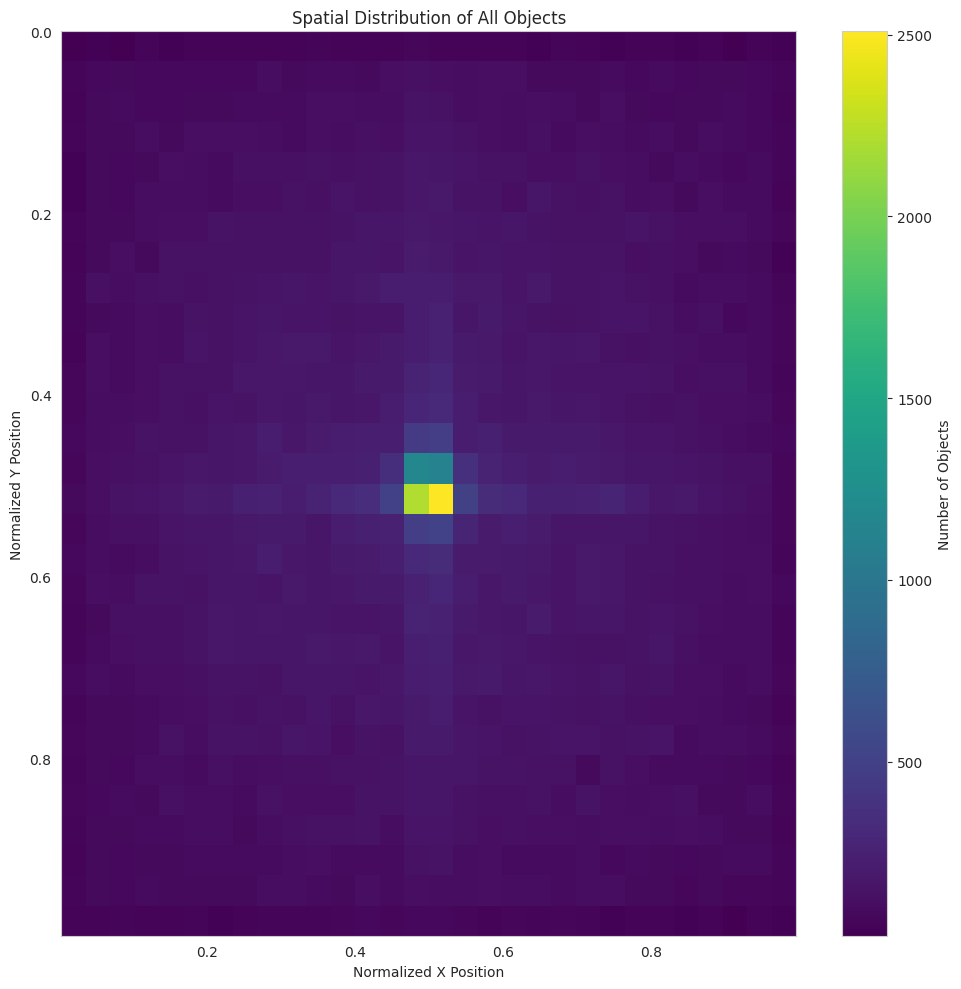

In [ ]:
# 1. Overall spatial distribution as heatmap
plt.figure(figsize=(10, 10))
plt.hist2d(x_centers, y_centers, bins=30, cmap='viridis')
plt.colorbar(label='Number of Objects')
plt.title('Spatial Distribution of All Objects')
plt.xlabel('Normalized X Position')
plt.ylabel('Normalized Y Position')
plt.gca().invert_yaxis()  # Invert Y axis to match image coordinates
plt.tight_layout()
plt.savefig('spatial_distribution_all.png')
plt.show()


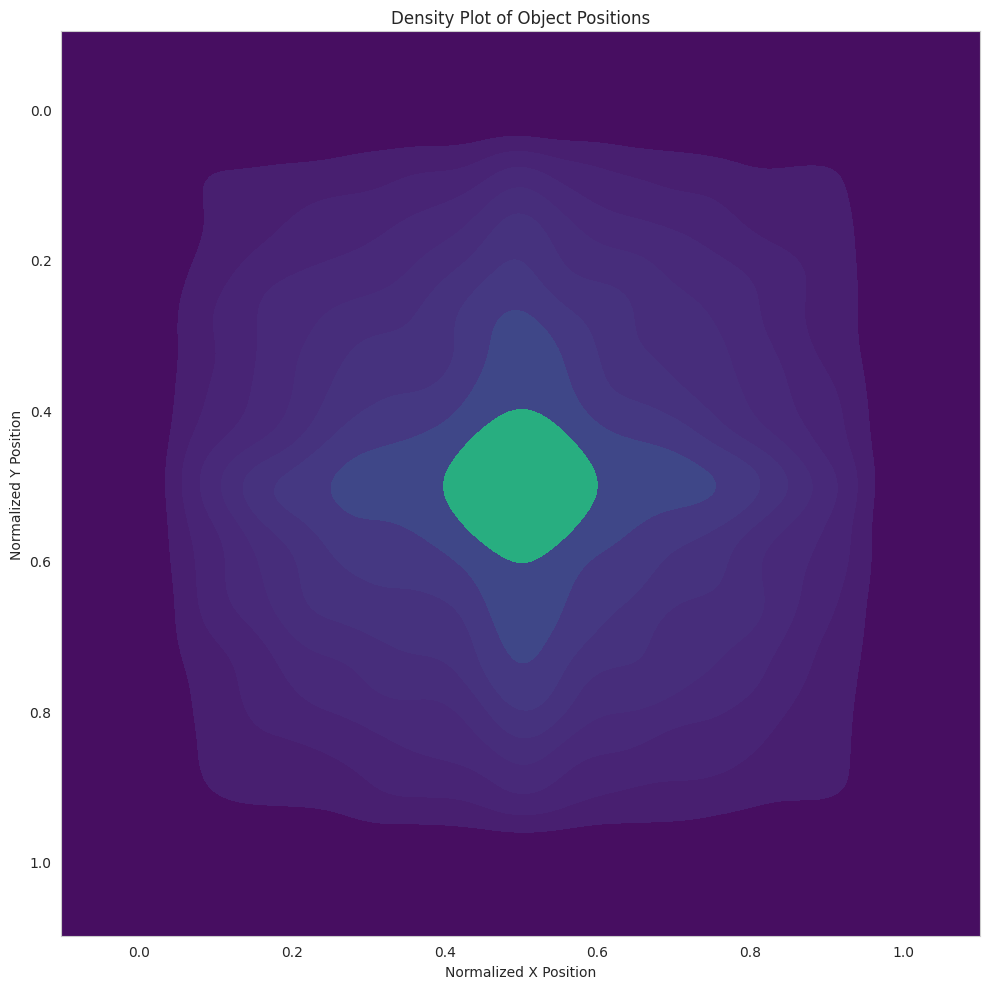

In [ ]:
# 2. Density plot using KDE (smoother visualization)
plt.figure(figsize=(10, 10))
sns.kdeplot(x=x_centers, y=y_centers, cmap="viridis", fill=True, thresh=0)
plt.title('Density Plot of Object Positions')
plt.xlabel('Normalized X Position')
plt.ylabel('Normalized Y Position')
plt.gca().invert_yaxis()  # Invert Y axis to match image coordinates
plt.tight_layout()
plt.savefig('spatial_density_all.png')
plt.show()

In [ ]:
# Calculate and print spatial statistics
print("\nSpatial Distribution Statistics:")

# Quadrant analysis (divide the image into 4 parts)
quadrants = {
    "Top-Left": 0,
    "Top-Right": 0,
    "Bottom-Left": 0,
    "Bottom-Right": 0
}

for x, y in zip(x_centers, y_centers):
    if x < 0.5 and y < 0.5:
        quadrants["Top-Left"] += 1
    elif x >= 0.5 and y < 0.5:
        quadrants["Top-Right"] += 1
    elif x < 0.5 and y >= 0.5:
        quadrants["Bottom-Left"] += 1
    else:
        quadrants["Bottom-Right"] += 1

total = len(x_centers)
print("Objects by quadrant:")
for quadrant, count in quadrants.items():
    print(f"  {quadrant}: {count} objects ({count/total*100:.1f}%)")

# Distance from center analysis
# Calculate normalized distance from center (0.5, 0.5)
distances = [np.sqrt((x-0.5)**2 + (y-0.5)**2) for x, y in zip(x_centers, y_centers)]
print("\nDistance from center (normalized):")
print(f"  Mean distance: {np.mean(distances):.3f}")
print(f"  Median distance: {np.median(distances):.3f}")
print(f"  Max distance: {np.max(distances):.3f}")

# Objects near edges (within 10% of any edge)
edge_margin = 0.1
edge_count = sum(1 for x, y in zip(x_centers, y_centers)
                 if x < edge_margin or x > (1-edge_margin) or
                    y < edge_margin or y > (1-edge_margin))
print(f"\nObjects near edges (within {edge_margin*100}% of image edge): {edge_count} ({edge_count/total*100:.1f}%)")

# Objects in the center region (middle 50% of the image)
center_margin = 0.25
center_count = sum(1 for x, y in zip(x_centers, y_centers)
                  if center_margin <= x <= (1-center_margin) and
                     center_margin <= y <= (1-center_margin))
print(f"Objects in center region (middle 50% of image): {center_count} ({center_count/total*100:.1f}%)")


Spatial Distribution Statistics:
Objects by quadrant:
  Top-Left: 30437 objects (24.8%)
  Top-Right: 30368 objects (24.8%)
  Bottom-Left: 30686 objects (25.0%)
  Bottom-Right: 31066 objects (25.3%)

Distance from center (normalized):
  Mean distance: 0.308
  Median distance: 0.319
  Max distance: 0.692

Objects near edges (within 10.0% of image edge): 25388 (20.7%)
Objects in center region (middle 50% of image): 51318 (41.9%)


### Co-occurence Analysis

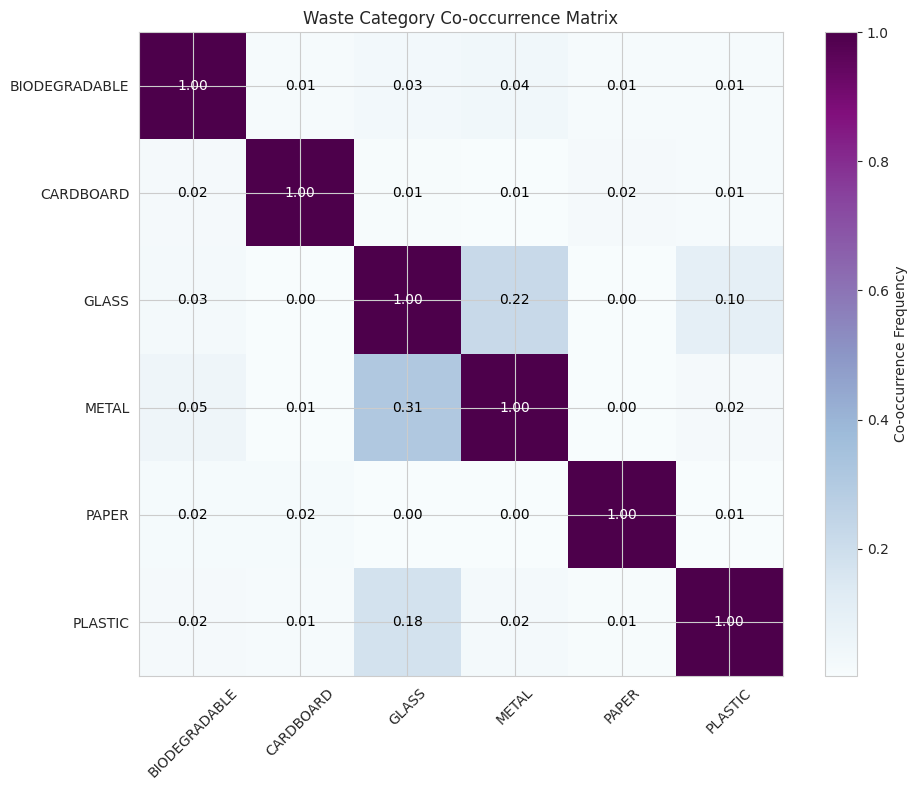

In [ ]:
# Create co-occurrence matrix
cooccurrence = np.zeros((len(classes), len(classes)))
image_classes = {}

# Collect class occurrences per image
for label_file in label_files:
    base_name = os.path.basename(label_file)
    classes_in_image = set()

    with open(label_file, 'r') as f:
        for line in f:
            values = line.strip().split()
            if len(values) == 5:
                class_id = int(values[0])
                if class_id < len(classes):
                    classes_in_image.add(class_id)

    # Save classes in this image
    image_classes[base_name] = classes_in_image

    # Update co-occurrence matrix
    for c1 in classes_in_image:
        for c2 in classes_in_image:
            cooccurrence[c1, c2] += 1

# Normalize by diagonal (self-occurrence)
norm_cooccurrence = np.zeros_like(cooccurrence, dtype=float)
for i in range(len(classes)):
    for j in range(len(classes)):
        if cooccurrence[i, i] > 0:
            norm_cooccurrence[i, j] = cooccurrence[i, j] / cooccurrence[i, i]

# Plot co-occurrence heatmap
plt.figure(figsize=(10, 8))
plt.imshow(norm_cooccurrence, cmap='BuPu')
plt.colorbar(label='Co-occurrence Frequency')
plt.title('Waste Category Co-occurrence Matrix')
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f'{norm_cooccurrence[i, j]:.2f}',
                ha='center', va='center',
                color='white' if norm_cooccurrence[i, j] > 0.5 else 'black')
plt.tight_layout()
plt.show()

### Annotation Quality Analysis

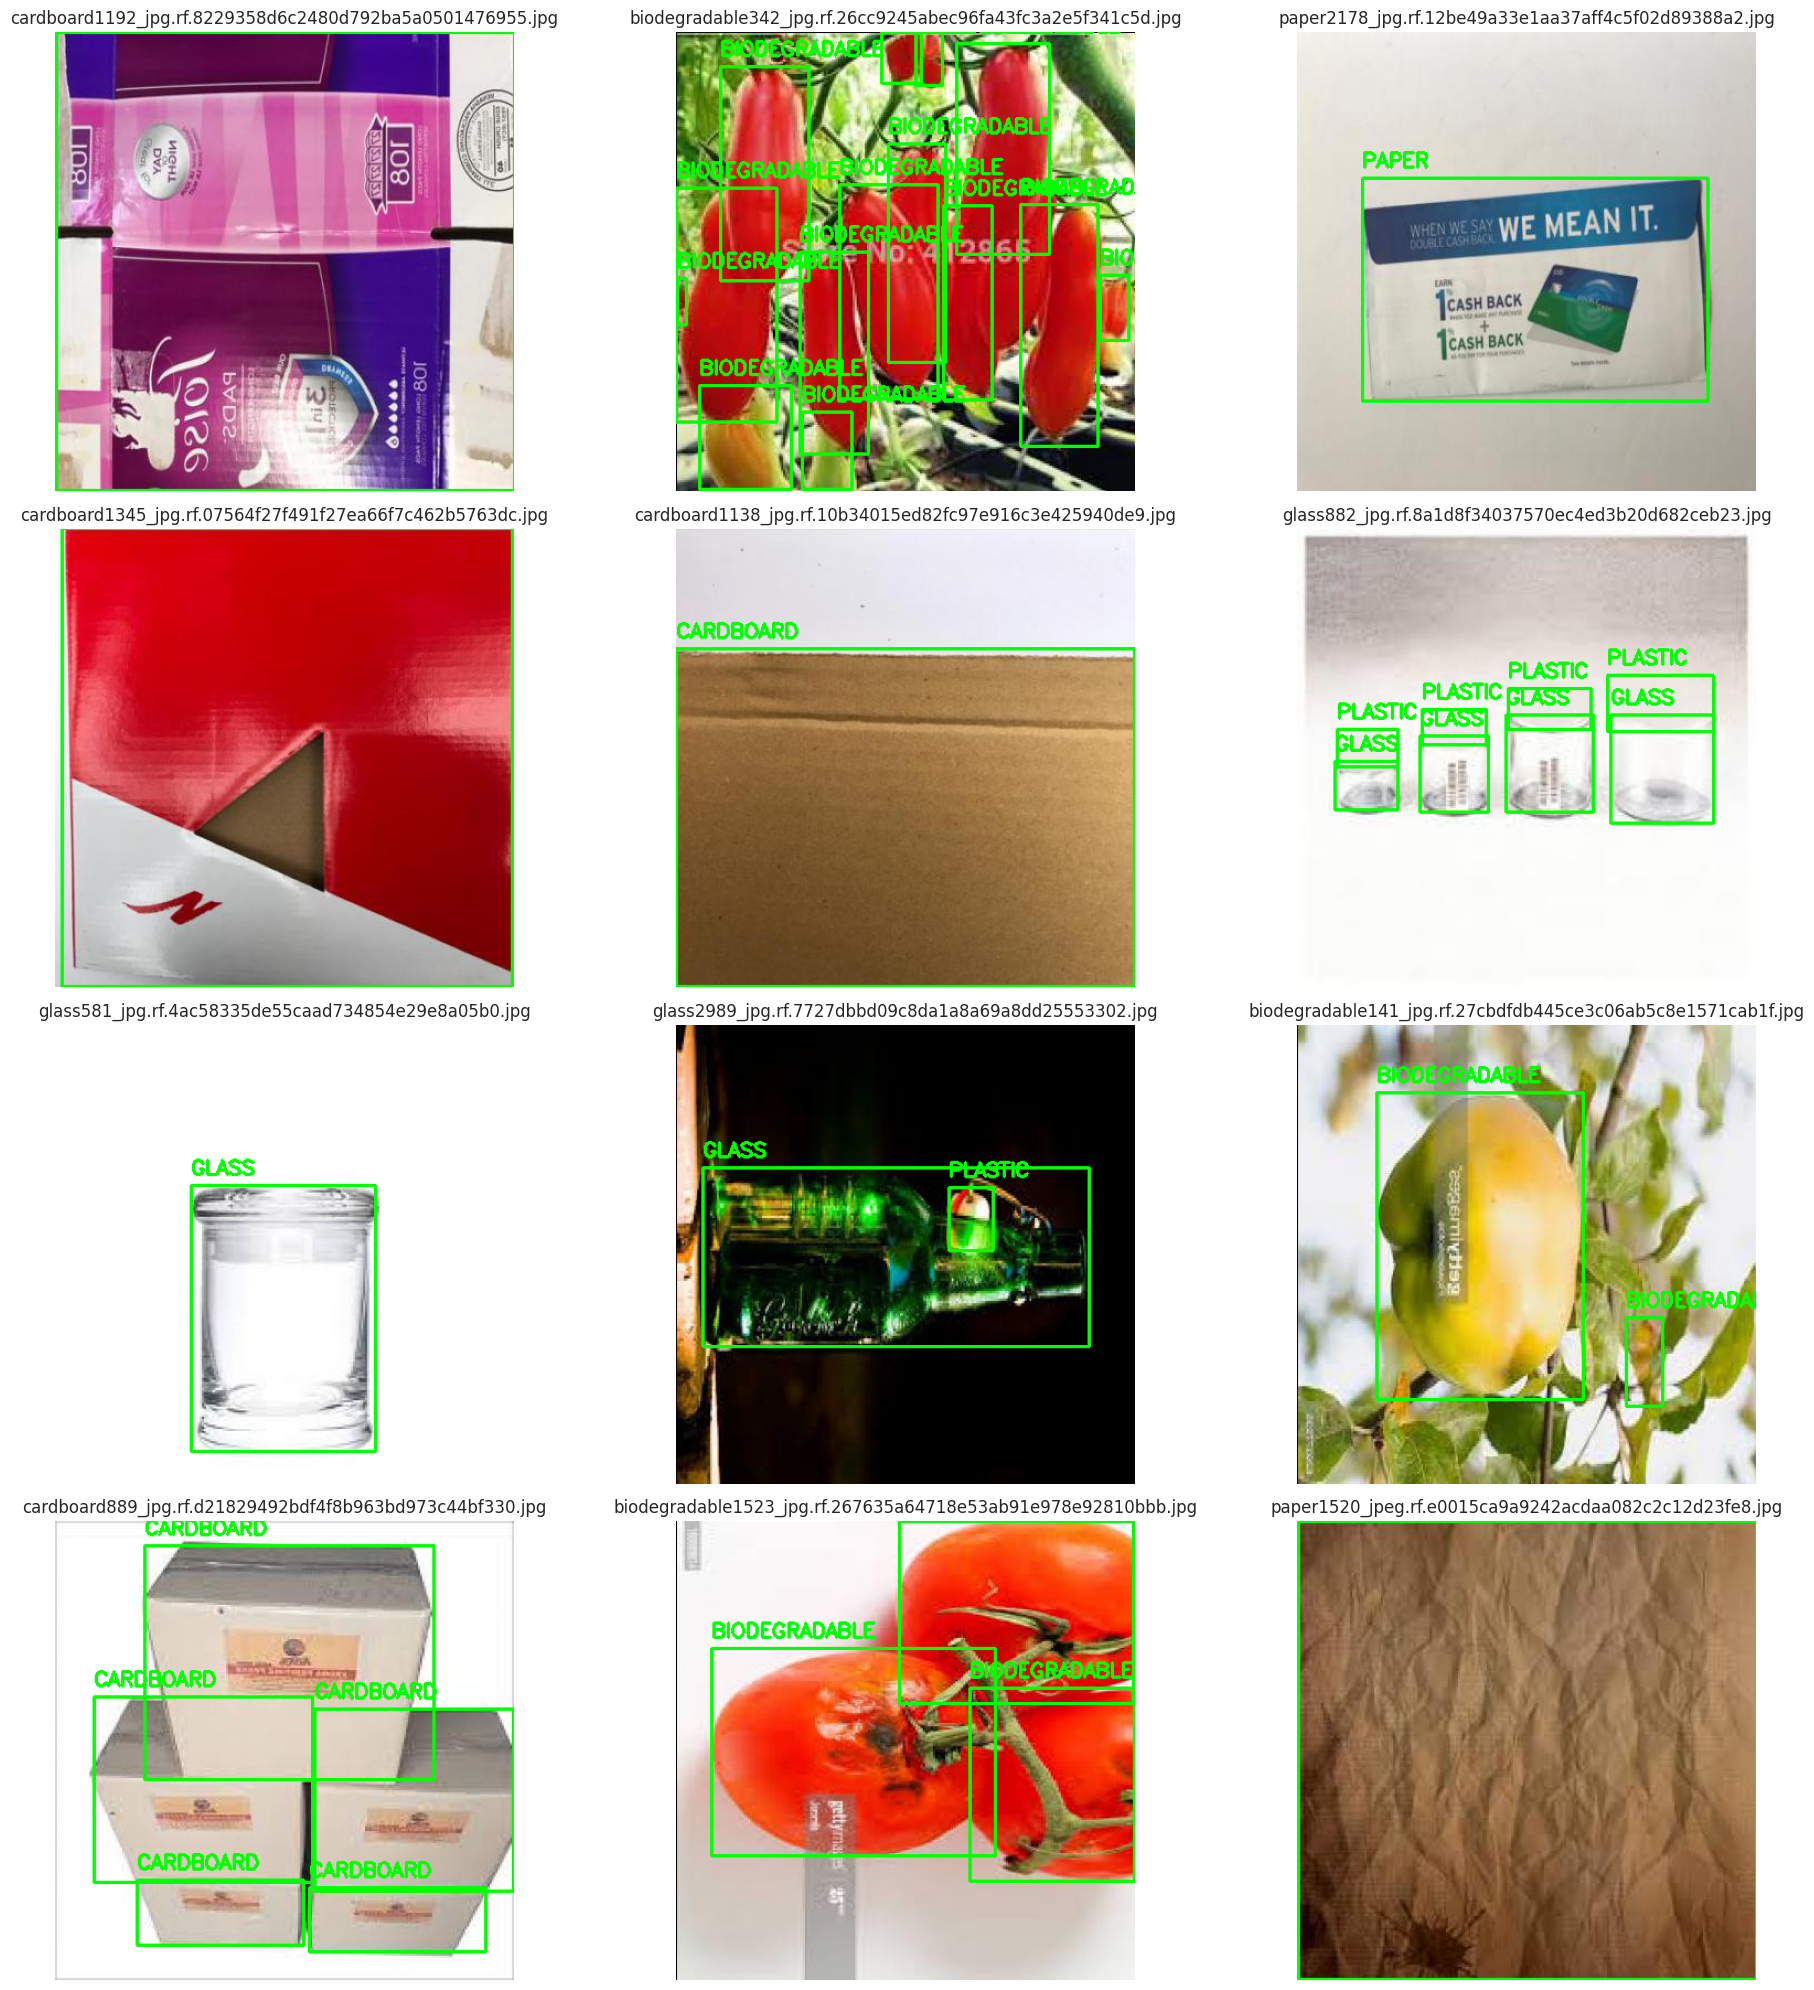

In [ ]:
# Function to plot image with bounding boxes
def plot_image_with_boxes(img_path, lbl_path, classes):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if not os.path.exists(lbl_path):
        return img  # If label doesn't exist, return raw image

    with open(lbl_path, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls_id, xc, yc, bw, bh = map(float, parts)

            # Convert YOLO format to pixel coordinates
            x1 = int((xc - bw/2) * w)
            y1 = int((yc - bh/2) * h)
            x2 = int((xc + bw/2) * w)
            y2 = int((yc + bh/2) * h)

            color = (0, 255, 0)  # Green
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

            label = classes[int(cls_id)]
            cv2.putText(img, label, (x1, max(y1-10, 0)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    return img

# Randomly select N images
N = 12  # or any number you want
sample_images = random.sample(image_files, N)

# Plot images
plt.figure(figsize=(20, 20))
for idx, img_path in enumerate(sample_images):
    img_name = os.path.basename(img_path)
    lbl_path = os.path.join(labels_path, os.path.splitext(img_name)[0] + ".txt")

    img_with_boxes = plot_image_with_boxes(img_path, lbl_path, classes)

    plt.subplot(4, 3, idx + 1)
    plt.imshow(img_with_boxes)
    plt.axis('off')
    plt.title(img_name)

plt.tight_layout()
plt.show()